### About:
The goal of this notebook is to perform a very simple sampling task using tensorflow probability.
Much of this is adapted from https://github.com/ksachdeva/rethinking-tensorflow-probability.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../src")

In [3]:
import collections
import numpy as np
import arviz as az
import pandas as pd

import scipy.stats as stats
from matplotlib import pyplot as plt

In [4]:
from sampling import tf_sampling as tfsamp

In [5]:
from plotting.tf_plotting import az_ppc_alternate as az_alt

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [7]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
CHERRY_BLOSSOMS_DATASET_PATH = f"{_BASE_URL}/cherry_blossoms.csv"

In [8]:
howel_data = pd.read_csv(HOWELL_DATASET_PATH, sep=";", header=0)
howel_data_adult = howel_data.query("age > 18")

In [9]:
howel_data_adult.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [10]:
def model():
    """
    Tensorflow Baysian inference model. From section 4.1 in 
    statistical rethinking. 
    Code adapted from  
    """

    def _generator():
        mu = yield Root(tfd.Normal(loc=0.0, scale=200.0))
        sigma = yield Root(tfd.Exponential(rate=0.1))
        height = yield tfd.Independent(
            tfd.Normal(loc=mu[..., None], scale=sigma[..., None]),
            reinterpreted_batch_ndims=1,
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


model_instance = model()

In [11]:
prior_predictive_distribution = model_instance.sample(5000)[-1]

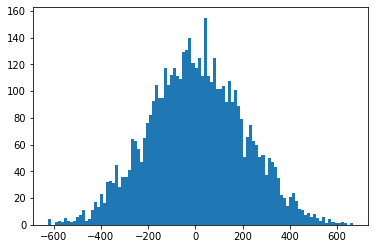

In [12]:
plt.hist(np.squeeze(prior_predictive_distribution.numpy()), bins=100);

In [13]:
raw_trace, az_inference_object = tfsamp.sample_posterior(
    model_instance,
    observed_data=(howel_data_adult.weight.values,),
    params=["mu", "sigma"],
    method="nuts",
    num_samples=1000,
)

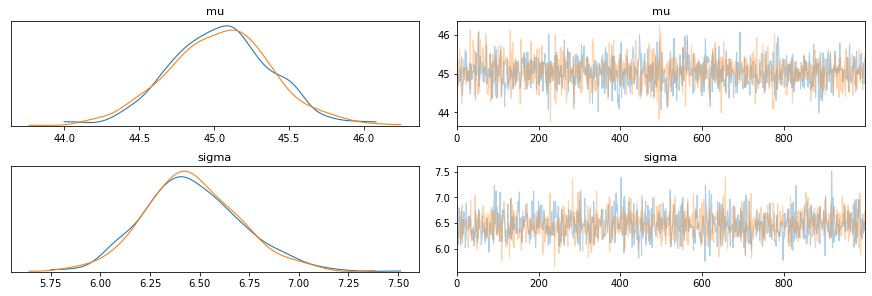

In [14]:
# the parameter chains are reasonable.
az.plot_trace(raw_trace);

45.04554285549133 6.455219659733352


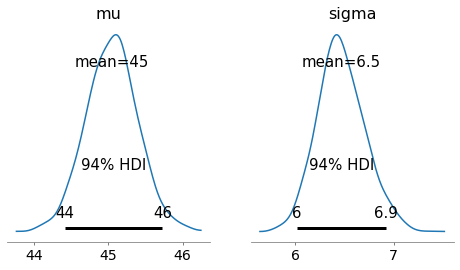

In [15]:
# inference looks accurate.
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_posterior(az_inference_object, ax=ax, var_names=["mu", "sigma"])
print(howel_data_adult["weight"].mean(), howel_data_adult["weight"].std())

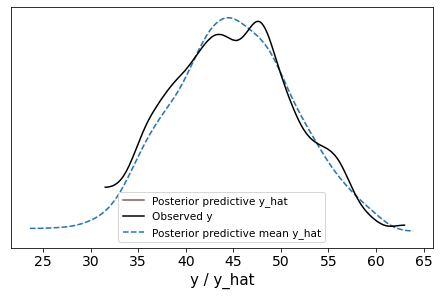

In [16]:
# There seems to be a problem with az posterior predictive plot for
# the way I've constructed the inference object. I've come up with a
# quick fix in the az_alt module
# todo: look deper into the spec to see if it is possible
# to format the data a better way.
# https://arviz-devs.github.io/arviz/schema/schema.html
az_alt.plot_ppc(
    az_inference_object,
    data_pairs={"y": "y_hat"},
    kind="kde",
    num_pp_samples=1000,
    jitter=20,
);